In [0]:
# ASSIGNMENT 7 - ENAS

from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, SeparableConv2D, Input
from keras.layers import Activation, Flatten, Dense, Dropout, Lambda, Reshape
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate
from keras.activations import softmax
from keras.utils import np_utils

import tensorflow as tf

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

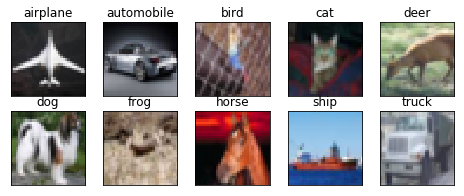

In [16]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
def space_to_depth(x, block_size=2):
    return tf.space_to_depth(x, block_size=block_size)

In [0]:
# Define the model
input = Input(shape=(32, 32, 3,))

layer1n = BatchNormalization(name='norm1')(input)
layer1 = SeparableConv2D(32, (5,5), padding='same', activation='relu', use_bias=False, name='layer1')(layer1n)

layer2n = BatchNormalization(name='norm2')(layer1)
layer2 = Conv2D(32, (5,5), padding='same', activation='relu', use_bias=False, name='layer2')(layer2n)

layer3n = BatchNormalization(name='norm3')(layer2)
layer3 = Conv2D(32, (5,5), padding='same', activation='relu', use_bias=False, name='layer3')(layer3n)

layer4n = BatchNormalization(name='norm4')(layer3)
input4 = concatenate([layer2n, layer4n]) 
layer4 = SeparableConv2D(32, (5,5), padding='same', activation='relu', use_bias=False, name='layer4')(input4)

layer1x1_1n = BatchNormalization(name='norm1x1_1')(layer4)
input1x1_1 = concatenate([layer1x1_1n, layer2n])
layer1x1_1 = Conv2D(32, (1,1), padding='same', activation='relu', use_bias=False, name='layer1x1_1')(input1x1_1)

max_pool1 = MaxPooling2D(pool_size=(2,2))(layer1x1_1)

layer5a = BatchNormalization(name='norm5')(max_pool1)
layer5 = SeparableConv2D(32, (3,3), padding='same', activation='relu', use_bias=False, name='layer5')(layer5a)

layer6a = BatchNormalization(name='norm6')(layer5)
layer2n_std = Lambda(lambda x: space_to_depth(x, 2))(layer2n)
layer1x1_1n_std = Lambda(lambda x: space_to_depth(x, 2))(layer1x1_1n)
input6 = concatenate([layer2n_std, layer6a, layer1x1_1n_std])
layer6 = Conv2D(32, (5,5), padding='same', activation='relu', use_bias=False, name='layer6')(layer6a)

layer7a = BatchNormalization(name='norm7')(layer6)
layer4n_std = Lambda(lambda x: space_to_depth(x, 2))(layer4n)
input7 = concatenate([layer6a, layer1x1_1n_std, layer4n_std, layer7a])
layer7 = SeparableConv2D(32, (3,3), padding='same', activation='relu', use_bias=False, name='layer7')(input7)

layer8a = BatchNormalization(name='norm8')(layer7)
input8 = concatenate([layer8a, layer6a, layer1x1_1n_std, layer7a, layer4n_std, layer2n_std])
layer8 = SeparableConv2D(32, (5,5), padding='same', activation='relu', use_bias=False, name='layer8')(input8)

layer1x1_2n = BatchNormalization(name='norm1x1_2')(layer8)
layer1x1_2 = Conv2D(32, (1,1), padding='same', activation='relu', use_bias=False, name='layer1x1_2')(layer1x1_2n)

input_max_pool2 = concatenate([layer1x1_2, layer8a, layer6a, layer2n_std, layer1x1_1n_std])
max_pool2 = MaxPooling2D(pool_size=(2,2))(input_max_pool2)

layer9a = BatchNormalization(name='norm9')(max_pool2)
layer7a_std = Lambda(lambda x: space_to_depth(x, 2))(layer7a)
input9 = concatenate([layer9a, layer7a_std])
layer9 = Conv2D(32, (5,5), padding='same', activation='relu', use_bias=False, name='layer9')(input9)

layer10a = BatchNormalization(name='norm10')(layer9)
layer8a_std = Lambda(lambda x: space_to_depth(x, 2))(layer8a)
layer3n_std = Lambda(lambda x: space_to_depth(x, 4))(layer3n)
layer1x1_1n_std2 = Lambda(lambda x: space_to_depth(x, 4))(layer1x1_1n)
input10 = concatenate([layer10a, layer8a_std, layer3n_std, layer1x1_1n_std2])
layer10 = SeparableConv2D(32, (5,5), padding='same', activation='relu', use_bias=False, name='layer10')(input10)

layer11a = BatchNormalization(name='norm11')(layer10)
layer6a_std = Lambda(lambda x: space_to_depth(x, 2))(layer6a)
layer4n_std2 = Lambda(lambda x: space_to_depth(x, 4))(layer4n)
input11 = concatenate([layer11a, layer6a_std, layer10a, layer4n_std2, layer3n_std])
layer11 = Conv2D(32, (3,3), padding='same', activation='relu', use_bias=False, name='layer11')(input11)

layer12a = BatchNormalization(name='norm12')(layer11)
layer2n_std2 = Lambda(lambda x: space_to_depth(x, 4))(layer2n)
input12 = concatenate([layer12a, layer4n_std2, layer8a_std, layer11a, layer1x1_1n_std2, layer6a_std, layer2n_std2])
layer12 = SeparableConv2D(32, (5,5), padding='same', activation='relu', use_bias=False, name='layer12')(input12)

layer1x1_3n = BatchNormalization(name='norm1x1_3')(layer12)
input1x1_3 = concatenate([layer1x1_3n, layer11a, layer1x1_1n_std2, layer8a_std])
layer1x1_3 = Conv2D(num_classes, (8,8), use_bias=False, name='layer1x1_3')(input1x1_3)

flatten = Flatten()(layer1x1_3)
output = Activation(softmax)(flatten)

model = Model(inputs=[input], outputs=[output])
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [34]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
norm1 (BatchNormalization)      (None, 32, 32, 3)    12          input_13[0][0]                   
__________________________________________________________________________________________________
layer1 (SeparableConv2D)        (None, 32, 32, 32)   171         norm1[0][0]                      
__________________________________________________________________________________________________
norm2 (BatchNormalization)      (None, 32, 32, 32)   128         layer1[0][0]                     
__________________________________________________________________________________________________
layer2 (Co

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`
  if sys.path[0] == '':


Epoch 1/100
390/390 [==============================] - 44s 113ms/step - loss: 2.6348 - acc: 0.4743 - val_loss: 2.4657 - val_acc: 0.4150
Epoch 2/100
390/390 [==============================] - 39s 100ms/step - loss: 0.9216 - acc: 0.7052 - val_loss: 1.1432 - val_acc: 0.6442
Epoch 3/100
390/390 [==============================] - 38s 98ms/step - loss: 0.4476 - acc: 0.8486 - val_loss: 1.2537 - val_acc: 0.6425
Epoch 4/100
390/390 [==============================] - 38s 99ms/step - loss: 0.2340 - acc: 0.9200 - val_loss: 1.4091 - val_acc: 0.6513
Epoch 5/100
390/390 [==============================] - 38s 99ms/step - loss: 0.1434 - acc: 0.9513 - val_loss: 1.5427 - val_acc: 0.6521
Epoch 6/100
390/390 [==============================] - 38s 98ms/step - loss: 0.1521 - acc: 0.9483 - val_loss: 1.9290 - val_acc: 0.6249
Epoch 7/100
390/390 [==============================] - 38s 99ms/step - loss: 0.2451 - acc: 0.9182 - val_loss: 2.0194 - val_acc: 0.6339
Epoch 8/100
390/390 [==============================] 

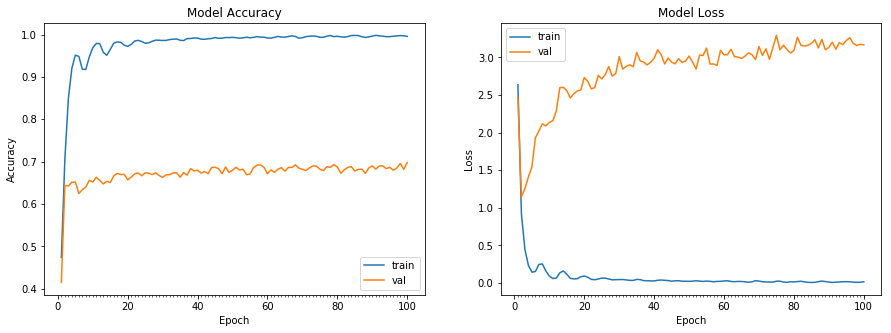

Accuracy on test data is: 69.79


In [35]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))